In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, GlobalMaxPool2D, Input, Flatten, Dropout
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator as Idg
import pandas as pd

Using TensorFlow backend.


In [0]:
# !wget -x --load-cookies cookies.txt https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download

--2020-03-31 20:02:43--  https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kaggle-data-sets/17810/23812/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1585944163&Signature=UDhq%2B14zvGsg68gl3DOgP9wvN8BycTl5uziNldmwlzM4BrUBxmm9gh6xNVRUIE3d%2BFFYApGq%2BAD0STlZXlQdYpMrEs4gDLIXvC6mZBZRKRS2cm338bfcrqMj%2FYrhPreLVd1b1B8gqV6EYwnvfcXo1ZJw4NIqDXrxRl0%2F9J7obbC5deZnRhd7UJ73H9QsWGtdPsZdi4VxQ1%2F3XfzgTKlw%2B1OA9bKHgJYqnEMXA%2F%2FHJJDy0pVdcQeOGgA2OCBlBTlLGqQRZWJUxcntnBzbx%2ByB3f6IW6WzID7999YnEAa21F%2FtfUP%2BeddTLRpwUQQKvC3pT%2FJMxHCJ0Q5V12grp2okVQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dchest-xray-pneumonia.zip [following]
--2020-03-31 20:02:43--  https://storage.googleapis.com/kaggle-data-se

In [0]:
# !mv www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download .

In [0]:
# !unzip -q download -d .

In [0]:
# New Model Using VGG16
imsize = (150,150)
inp = Input(shape=(*imsize,3))
mod = VGG16(include_top =False, input_tensor=inp, weights='imagenet')
mod.trainable=False
mod = GlobalMaxPool2D()(mod.output)

mod = Dense(150, activation='relu')(mod)
mod = Dropout(0.2)(mod)
mod = Dense(100, activation='relu')(mod)
mod = Dense(1, activation='sigmoid')(mod)
mod = Model(inputs=inp, outputs=mod)

# for layer in mod.layers[:-4]:
#   layer.trainable = False

mod.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator as Idg
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split as tts
from sklearn.utils import shuffle
import random
import seaborn as sns
from keras import backend as K

In [0]:
trainpath = 'chest_xray/train/'
testpath = 'chest_xray/test/'
valpath = 'chest_xray/val/'

In [0]:
# List of file names
trNormalList = os.listdir(trainpath+'NORMAL')
trPneList = os.listdir(trainpath+'PNEUMONIA')
print((len(trNormalList),len(trPneList)))
tsNormalList = os.listdir(testpath+'NORMAL')
tsPneList = os.listdir(testpath+'PNEUMONIA')
print((len(tsNormalList),len(tsPneList)))

(1341, 3875)
(234, 390)


In [0]:
y_tr = np.array([0 for i in range(len(trNormalList))]+[1 for i in range(len(trPneList))])
y_tr = y_tr.reshape(y_tr.shape[0],1)


y_ts = np.array([0 for i in range(len(tsNormalList))]+[1 for i in range(len(tsPneList))])
y_ts = y_ts.reshape(y_ts.shape[0],1)
y_tr.shape,y_ts.shape

((5216, 1), (624, 1))

In [0]:
X_tr = ['NORMAL/'+ i for i in trNormalList] + ['PNEUMONIA/'+i for i in trPneList]
X_ts = ['NORMAL/'+ i for i in tsNormalList] + ['PNEUMONIA/'+i for i in tsPneList]
len(X_tr), len(X_ts)

(5216, 624)

In [0]:
X_train , y_train = shuffle(X_tr, y_tr, random_state=42)
X_test, y_test = X_ts, y_ts
len(X_train), y_train.shape, len(X_test), y_test.shape

(5216, (5216, 1), 624, (624, 1))

In [0]:
def getImg(path):
  img = plt.imread(path)
  if img.shape[-1]!=3:
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
  return cv2.resize(img,imsize,interpolation=cv2.INTER_CUBIC)/255

(150, 150, 3)

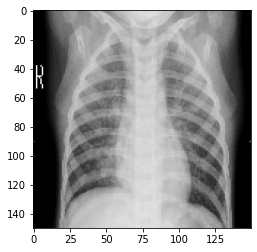

In [0]:
i = random.randint(0,len(y_train)-1)
plt.imshow(getImg(trainpath+X_train[i]))
getImg(trainpath+X_train[i]).shape

In [0]:
# Getting images as numpy array
X_train = np.array([ getImg(trainpath+X_train[i]) for i in range(len(X_train))])
X_test = np.array([ getImg(testpath+X_test[i]) for i in range(len(X_test))])
X_train.shape, X_test.shape

((5216, 150, 150, 3), (624, 150, 150, 3))

In [0]:
import tensorflow as tf


In [0]:
 # EarlyStopping to avoid overfitting
 es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.array([0,1]), y_train.reshape(y_train.shape[0],))
class_weights

array([1.9448173 , 0.67303226])

In [0]:
#Training the model
mod.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
mod.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test,y_test), callbacks=[es], class_weight={0:2.8,1:1})

Train on 5216 samples, validate on 624 samples
Epoch 1/2
5216/5216 [==============================] - 23s 4ms/step - loss: 0.8846 - acc: 0.6979 - val_loss: 0.6002 - val_acc: 0.7468
Epoch 2/2
5216/5216 [==============================] - 21s 4ms/step - loss: 0.4098 - acc: 0.8878 - val_loss: 0.3739 - val_acc: 0.8526


In [0]:
mod.evaluate(X_test,y_test)

624/624 [==============================] - 1s 1ms/step


[0.3739177290445719, 0.8525641025641025]

In [0]:
valNormalList = os.listdir(valpath+'NORMAL')
valPneList = os.listdir(valpath+'PNEUMONIA')
print((len(valNormalList),len(valPneList)))

(8, 8)


In [0]:
# mod.save('drive/My Drive/pnemodel.h5')

In [0]:
pred = mod.predict(X_test)


In [0]:
pred_ = pred>0.5

In [0]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr

In [0]:
print(cr(y_test, pred_))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       234
           1       0.88      0.89      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624



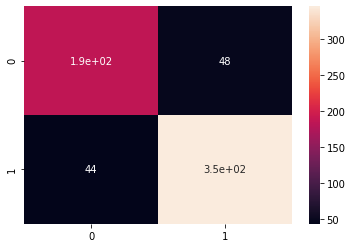

In [0]:
pred_ = pred>0.5
sns.heatmap(cm(y_test, pred_),annot =True)

In [0]:
model = load_model('pnemodel.h5')
model.evaluate(X_test, y_test)

624/624 [==============================] - 3s 4ms/step


[1.0235163844071138, 0.8189102564102564]

In [0]:
del X_test
del X_train

NameError: ignored

In [0]:
import gc
collect = gc.collect()
collect

0

In [0]:
mod.save('pnev2.h5')